In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


# Load data

In [3]:
dataset = pandas.read_csv('../input/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataset.values
dataset = dataset.astype('float32')

# LSTM

In [4]:
# Fix the random seed
np.random.seed(7)

## Prepairing the data

In [5]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)

In [6]:
# Split dataset into train and test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

In [7]:
train, test = scaled_dataset[0:train_size,:], scaled_dataset[train_size:len(dataset),:]

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

**Old reshape method**:
```Python
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
```

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Running model

```python
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
```

In [11]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
for i in range(100):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0287
Epoch 1/1
0s - loss: 0.0197
Epoch 1/1
0s - loss: 0.0093
Epoch 1/1
0s - loss: 0.0116
Epoch 1/1
0s - loss: 0.0078
Epoch 1/1
0s - loss: 0.0067
Epoch 1/1
0s - loss: 0.0049
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0044
Epoch 1/1
0s - loss: 0.0049
Epoch 1/1
0s - loss: 0.0047
Epoch 1/1
0s - loss: 0.0044
Epoch 1/1
0s - loss: 0.0042
Epoch 1/1
0s - loss: 0.0042
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0040
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0038
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
0s - loss: 0.0035
Epoch 1/1
0s - loss: 0.0034
Epoch 1/1
0s - loss: 0.0033
Epoch 1/1
0s - loss: 0.0032
Epoch 1/1
0s - loss: 0.0034
Epoch 1/1
0s - loss: 0.0035
Epoch 1/1
0s - loss: 0.0034
Epoch 1/1
0s - loss: 0.0033
Epoch 1/1
0s - loss:

## Making prediction

```Python
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
```

In [13]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

In [14]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.92 RMSE
Test Score: 101.07 RMSE


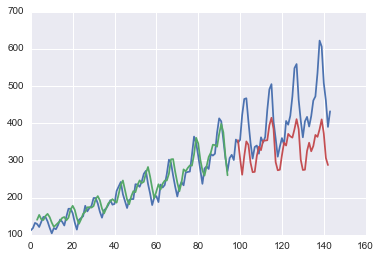

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled_dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
plt.close()